In [3]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark\\spark-2.4.5-bin-hadoop2.7'

In [4]:
data_path = 'C://Users/Ram Ganesh/Downloads/datascience_challenge/'

In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName('appName').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)


In [48]:
#Read the input data
category_df = spark.read.csv(data_path + 'Category.tsv/Category.tsv', sep='\t', header=True)
location_df = spark.read.csv(data_path + 'Location.tsv/Location.tsv', sep='\t', header=True)
phonereq_df = spark.read.csv(data_path + 'PhoneRequestsStream.tsv/PhoneRequestsStream.tsv', sep='\t', header=True)
search_df   = spark.read.csv(data_path + 'Search/SearchInfo.tsv', sep='\t', header=True)
visits_df   = spark.read.csv(data_path + 'Visits/VisitsStream.tsv', sep='\t', header=True)
adsinfo_df  = spark.read.csv(data_path + 'AdsInfo/AdsInfo.tsv', sep='\t', header=True)
users_df    = spark.read.csv(data_path + 'Users/UserInfo.tsv', sep='\t', header=True)
train_df    = spark.read.csv(data_path + 'trainSearchStream.tsv/trainSearchStream.tsv', sep='\t', header=True)

In [49]:
#Print sample of data
category_df.show(5)
location_df.show(5)
phonereq_df.show(5)
search_df.show(5)
visits_df.show(5)
adsinfo_df.show(5)
users_df.show(5)
train_df.show(5)

+----------+-----+----------------+-------------+
|CategoryID|Level|ParentCategoryID|SubcategoryID|
+----------+-----+----------------+-------------+
|         0|    1|              10|           45|
|         1|    2|               9|           45|
|         2|    3|              12|            5|
|         3|    3|               9|           25|
|         4|    3|               2|           39|
+----------+-----+----------------+-------------+
only showing top 5 rows

+----------+-----+--------+------+
|LocationID|Level|RegionID|CityID|
+----------+-----+--------+------+
|         7|    3|      83|  2386|
|        23|    3|      28|  3224|
|        26|    3|      41|  1316|
|        30|    3|      63|  2565|
|        32|    3|      28|  2819|
+----------+-----+--------+------+
only showing top 5 rows

+-------+-------+--------+--------------------+
| UserID|   IPID|    AdID|    PhoneRequestDate|
+-------+-------+--------+--------------------+
| 352278|2135799|11720717|2015-04-25 00:0

In [ ]:
train_df.groupBy('IsClick').count().show()
#+-------+---------+
#|IsClick|    count|
#+-------+---------+
#|      0|189011446|
#|   null|202199213|
#|      1|  1146289|
#+-------+---------+
#filter and store only the context data
#train_df.filter(train_df.IsClick != 'null').write.csv(data_path+'results/filtered_train_data.csv', header=True, sep='\t')
filtered_train_df    = spark.read.csv(data_path + 'results/filtered_train_data.csv', sep='\t', header=True)
#+-------+---------+
#|IsClick|    count|
#+-------+---------+
#|      0|189011446|
#|      1|  1146289|
#+-------+---------+

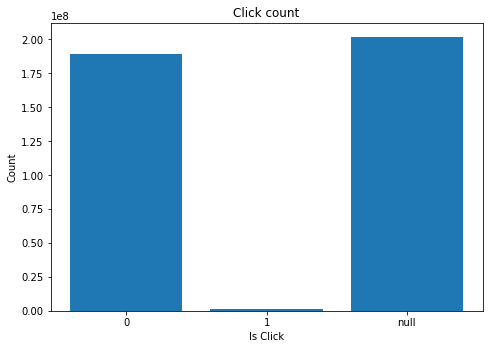

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
IsClick = ['0', '1', 'null']
count = [189011446,1146289,202199213]
ax.bar(IsClick,count)
plt.ylabel('Count')
plt.xlabel('Is Click')
plt.title('Click count')
plt.show()

In [ ]:
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as psf
filtered_train_df = filtered_train_df.withColumn("IsClick", filtered_train_df["IsClick"].cast(IntegerType()))
conv_per_context = filtered_train_df.groupBy("ObjectType").agg(psf.sum("IsClick"),psf.count("IsClick"))
conv_per_context_pd = conv_per_context.toPandas()
#  ObjectType  sum(IsClick)  count(IsClick)   ctr
#0          3       1146289       190157735   0.6028
conv_per_position = filtered_train_df.groupBy("Position").agg(psf.sum("IsClick"),psf.count("IsClick"))
conv_per_position_pd = conv_per_position.toPandas()
#  Position  sum(IsClick)  count(IsClick)    ctr
#0        7        372904        82294271    0.453
#1        1        773385       107863464    0.717

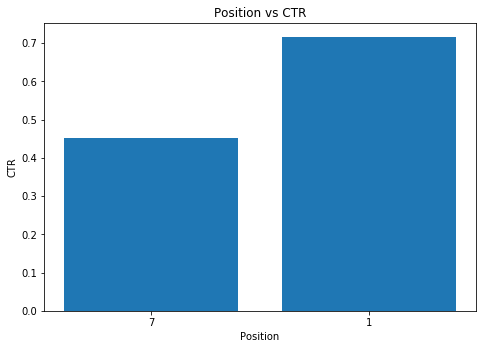

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Position = ['7', '1']
CTR = [0.453,0.717]
ax.bar(Position,CTR)
plt.ylabel('CTR')
plt.xlabel('Position')
plt.title('Position vs CTR')
plt.show()

In [14]:
#+----------+---------+
#|ObjectType|    count|
#+----------+---------+
#|         3|190157735|    
#|         1|162668459|    
#|         2| 39530754|    
#+----------+---------+


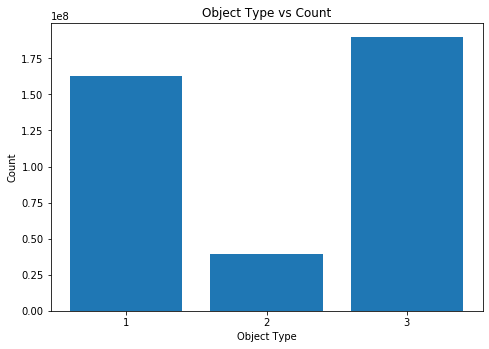

In [8]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Object_type = ['1', '2','3']
count = [162668459,39530754, 190157735]
ax.bar(Object_type,count)
plt.ylabel('Count')
plt.xlabel('Object Type')
plt.title('Object Type vs Count')
plt.show()

In [ ]:
#Rename columns
location_df = location_df.withColumnRenamed('Level', 'Loc_level')
category_df = category_df.withColumnRenamed('Level', 'Cat_level')

In [ ]:
#Join all the tables
train_adinfo = filtered_train_df.join(adsinfo_df, ['AdID'], how='inner')
train_adinfo_loc = train_adinfo.join(location_df, ['LocationID'], how='left')
train_adinfo_loc_cat = train_adinfo_loc.join(category_df, ['CategoryID'], how='left')
train_adinfo_loc_cat.write.csv(data_path + 'results/train_adinfo_loc_cat.csv', header=True)

In [ ]:
train_adinfo = spark.read.csv(data_path + 'results/final_data2.csv', header=True)
train_adinfo_loc_cat = spark.read.csv(data_path + 'results/train_adinfo_loc_cat.csv', header=True)
#+----------+---------+
#|LocationID|    count|
#+----------+---------+
#|      null|190157735|
#+----------+---------+
search_df = search_df.withColumnRenamed('LocationID', 'search_LocationID').withColumnRenamed('CategoryID', 'search_CategoryID')
search_df = search_df.drop('SearchQuery','SearchParams','IPID')
final_df = train_adinfo_loc_cat.drop('Params', 'Title','LocationID','Loc_level','RegionID','CityID').join(search_df, ['SearchID'], how='inner')
final_df.write.csv(data_path + 'results/final_data.csv', header=True)

final_df = spark.read.csv(data_path + 'results/final_data.csv', header=True)
final_df = final_df.drop('LocationID','Loc_level','RegionID','CityID','search_CategoryID').join(users_df, ['UserID'], how='inner')
final_df = final_df.withColumnRenamed('search_LocationID', 'LocationID' )
final_df = final_df.join(location_df, ['LocationID'], how='left')
#final_df = final_df.join(category_df, ['CategoryID'], how='left')
final_df.write.csv(data_path + 'results/final_train_data.csv', header=True)
final_train_data = spark.read.csv(data_path + 'results/final_train_data.csv', header=True)

In [5]:
final_train_data = spark.read.csv(data_path + 'results/final_train_data.csv', header=True)
#Sample the final train data since constrained by resources for running in local on full data
sample = final_train_data.sample(False, 0.01, seed=0)
sample.write.csv(data_path + 'results/train_data.csv', header=True)

+----------+-------+--------+----------+--------+--------+----------+--------+-------+------+---------+---------+----------------+-------------+--------------------+--------------+-----------+-------------+------------+-----------------+---------+--------+------+
|LocationID| UserID|SearchID|CategoryID|    AdID|Position|ObjectType| HistCTR|IsClick| Price|IsContext|Cat_level|ParentCategoryID|SubcategoryID|          SearchDate|IsUserLoggedOn|UserAgentID|UserAgentOSID|UserDeviceID|UserAgentFamilyID|Loc_level|RegionID|CityID|
+----------+-------+--------+----------+--------+--------+----------+--------+-------+------+---------+---------+----------------+-------------+--------------------+--------------+-----------+-------------+------------+-----------------+---------+--------+------+
|      3960|1000016|63640085|        36|33262923|       1|         3|0.002486|      0|159990|        1|        3|              12|            6|2015-05-19 11:42:...|             0|      23170|           20|  

In [6]:
sample = spark.read.csv(data_path + 'results/train_data.csv', header=True)
sample.show()

+----------+-------+---------+----------+--------+--------+----------+--------+-------+-----+---------+---------+----------------+-------------+--------------------+--------------+-----------+-------------+------------+-----------------+---------+--------+------+
|LocationID| UserID| SearchID|CategoryID|    AdID|Position|ObjectType| HistCTR|IsClick|Price|IsContext|Cat_level|ParentCategoryID|SubcategoryID|          SearchDate|IsUserLoggedOn|UserAgentID|UserAgentOSID|UserDeviceID|UserAgentFamilyID|Loc_level|RegionID|CityID|
+----------+-------+---------+----------+--------+--------+----------+--------+-------+-----+---------+---------+----------------+-------------+--------------------+--------------+-----------+-------------+------------+-----------------+---------+--------+------+
|       163|1000727| 92818614|        47|29290269|       1|         3|0.009934|      0| 3090|        1|        3|               3|           28|2015-05-18 21:15:...|             0|      30644|           43|  

In [19]:
cols = sample.columns
#convert from string to float
from pyspark.sql.types import FloatType
sample = sample.withColumn("HistCTR", sample["HistCTR"].cast(FloatType()))
sample = sample.withColumn("Price", sample["Price"].cast(FloatType()))


In [31]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#Index and one-hot encode categorical columns
categorical_coulmns = ['Position','ParentCategoryID','SubcategoryID',
                       'IsUserLoggedOn','UserAgentID', 'UserAgentOSID','UserDeviceID','UserAgentFamilyID',
                       'RegionID', 'CityID']
stages = []
for catcol in categorical_coulmns:
    stringIndexer = StringIndexer(inputCol = catcol, outputCol = catcol + 'Index',handleInvalid="skip")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[catcol + "classVec"])
    stages += [stringIndexer, encoder]
    
label_stringIdx = StringIndexer(inputCol = 'IsClick', outputCol = 'label',handleInvalid="skip")
stages += [label_stringIdx]


numericCols = ['HistCTR', 'Price']
assemblerInputs = [c + "classVec" for c in categorical_coulmns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [32]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(sample)
df = pipelineModel.transform(sample)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- LocationID: string (nullable = true)
 |-- UserID: string (nullable = true)
 |-- SearchID: string (nullable = true)
 |-- CategoryID: string (nullable = true)
 |-- AdID: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- ObjectType: string (nullable = true)
 |-- HistCTR: float (nullable = true)
 |-- IsClick: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- IsContext: string (nullable = true)
 |-- Cat_level: string (nullable = true)
 |-- ParentCategoryID: string (nullable = true)
 |-- SubcategoryID: string (nullable = true)
 |-- SearchDate: string (nullable = true)
 |-- IsUserLoggedOn: string (nullable = true)
 |-- UserAgentID: string (nullable = true)
 |-- UserAgentOSID: string (nullable = true)
 |-- UserDeviceID: string (nullable = true)
 |-- UserAgentFamilyID: string (nullable = true)
 |-- Loc_level: string (nullable = true)
 |-- RegionID: string (nullable = true)

In [33]:
import pandas as pd
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
LocationID,163,3679,3953,212,2319
UserID,1000727,1001516,1002235,1002850,10035
SearchID,92818614,36243385,49645280,9930371,40000806
CategoryID,47,38,25,34,34
AdID,29290269,18294552,11297621,33035050,32622796
Position,1,1,7,7,1
ObjectType,3,3,3,3,3
HistCTR,0.009934,0.007823,0.0125,0.042429,0.090682


In [34]:
#Split the data into training and testing
train, test = df.randomSplit([0.7, 0.3], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 1290355
Test Dataset Count: 553872


In [35]:
#Fit a LR model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)


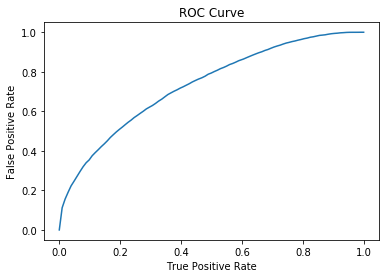

Training set areaUnderROC: 0.73245018752254


In [39]:
import matplotlib.pyplot as plt
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))


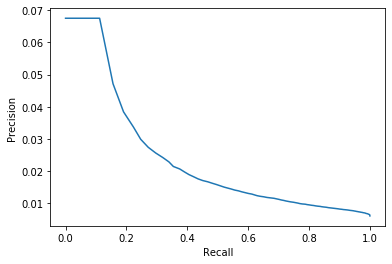

In [40]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


In [41]:
predictions = lrModel.transform(test)
predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(10)


+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[5.83085837292583...|       0.0|[0.99707303616994...|
|  0.0|[5.83086519053341...|       0.0|[0.99707305606635...|
|  0.0|[5.82513471968383...|       0.0|[0.99705628466560...|
|  0.0|[5.82049547762849...|       0.0|[0.99704263681180...|
|  0.0|[5.82006752648770...|       0.0|[0.99704137467926...|
|  0.0|[5.81882413767472...|       0.0|[0.99703770457388...|
|  0.0|[5.81842546145661...|       0.0|[0.99703652684225...|
|  0.0|[5.81671366757751...|       0.0|[0.99703146471456...|
|  0.0|[5.81637448894061...|       0.0|[0.99703046067046...|
|  0.0|[5.81630977375122...|       0.0|[0.99703026906067...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [42]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


Test Area Under ROC 0.6136698146103157


In [43]:
sc.stop()
